# Notebook for MVPA-GAT analysis

- create MVPA pipeline
- apply MVPA to epoched data
- stats on MVPA data
- visualize results

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context('paper')

import mne
from autoreject import LocalAutoRejectCV
mne.set_log_level('ERROR')

import pandas as pd
import scipy.stats as stats
from os import listdir
import numpy as np
import pickle


df = pd.read_csv('~/conincon_data/lookUp.csv') # location of lookup csv

template = "~/conincon_data/files/{}-on_ica-epo.fif" # location of epoched data

event_id_sentences = {"con/hc":201, "con/lc":200, "inc/lc":210, "inc/hc":211}
loc_files = "~/conincon_data/files/"


/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
bads = ["VLA21", # not a native speaker of German
        "GMA05","RAC22","PBT16","HHA01","BSN17"]

In [7]:
names = list({fname.split("-")[0]  # the names of all datasets
              for fname in listdir(loc_files) 
              if "on_ica" in fname and fname.split("-")[0] not in bads
             })

In [25]:
def get_epochs(name):
    '''
    loads the epoched data for participant (name)
    '''
    epoch = mne.read_epochs(template.format(name))
    return epoch


times = get_epochs(names[0]).times # gets the array of time points for epoched data
l_times = list(times) # and creates a list

# Define functions

In [26]:
# statistics tests used

def _my_wilcoxon(X):
    from scipy.stats import wilcoxon
    out = wilcoxon(X)
    return out[1]

def _loop(x, function):
    out = list()
    for ii in range(x.shape[1]):
        out.append(function(x[:, ii]))
    return out

def parallel_stats(X, function=_my_wilcoxon, correction='FDR', n_jobs=-1):
    from mne.parallel import parallel_func
    import numpy as np
    from mne.stats import fdr_correction

    if correction not in [False, None, 'FDR']:
        raise ValueError('Unknown correction')
    # reshape to 2D
    X = np.array(X)
    dims = X.shape
    X.resize([dims[0], np.prod(dims[1:])])
    # prepare parallel
    n_cols = X.shape[1]
    parallel, pfunc, n_jobs = parallel_func(_loop, n_jobs)
    n_chunks = min(n_cols, n_jobs)
    chunks = np.array_split(range(n_cols), n_chunks)
    p_values = parallel(pfunc(X[:, chunk], function) for chunk in chunks)
    p_values = np.reshape(np.hstack(p_values), dims[1:])
    X.resize(dims)
    # apply correction
    if correction == 'FDR':
        dims = p_values.shape
        _, p_values = fdr_correction(p_values)
        p_values = np.reshape(p_values, dims)
    return p_values


def _stat_fun(x, sigma=0, method='relative'):
    from mne.stats import ttest_1samp_no_p
    import numpy as np
    t_values = ttest_1samp_no_p(x, sigma=sigma, method=method)
    t_values[np.isnan(t_values)] = 0
    return t_values


def stats_tfce(X, n_permutations=2**10,threshold=dict(start=.1, step=.1), n_jobs=2):
    # threshold free cluster enhancement for GATs
    import numpy as np
    from mne.stats import spatio_temporal_cluster_1samp_test

    X = np.array(X)
    T_obs_, clusters, p_values, _ = spatio_temporal_cluster_1samp_test(
    X,out_type='mask',
    stat_fun=_stat_fun,
    n_permutations=n_permutations,
    threshold=threshold,
    n_jobs=n_jobs)
    p_values = p_values.reshape(X.shape[1:])
    return p_values

# GAT Decoding

In [27]:
def get_gat(name):
    """
    Create a GAT object.
    """
    class1 = [201]
    epoch = get_epochs(name)
    times=epoch.times
    labels = np.in1d(epoch.events[:, 2], class1)
    scaler = StandardScaler()
    clf = RidgeClassifier(class_weight='balanced')
    pipe = Pipeline([('scaler', scaler), ('clf', clf)])
    gat = GAT(clf=pipe, predict_method="decision_function",
              cv=StratifiedKFold(labels, 5, shuffle=True),
              scorer=scorer_auc, n_jobs=12)
    gat.fit(epoch, labels)
    scores = gat.score(epoch, labels)
    return gat

In [28]:
def scorer_auc(y_true, y_pred):
    """Dedicated to 2class probabilistic outputs"""
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import LabelBinarizer
    le = LabelBinarizer()
    y_true = le.fit_transform(y_true)
    return roc_auc_score(y_true, y_pred)

In [89]:
event_id_sentences

{'con/hc': 201, 'con/lc': 200, 'inc/hc': 211, 'inc/lc': 210}

In [90]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import StratifiedKFold

from mne.decoding.time_gen import GeneralizationAcrossTime as GAT

def run_gat(name, class1, decoder="ridge"):
    """
    Run Generalization Across Time (GAT).

    Attributes:
        epochs(list): List of individual epochs.
        class1(list): Trigger event(s) to be classes as class1 (remaining as class2)
        decoder(str): Specify type of classifier - 'ridge' for Ridge Regression (default),'svm' for SVM and 
                        'log_reg' for Logistic Regression
    """
    # get labels for for events to be classified
    epochs = get_epochs(name)["hc"]
    labels = np.in1d(epochs.events[:, 2], class1)
    scaler = StandardScaler()
    
    # specify whether to use a linear or nonlinear SVM if SVM is used
    lin = '' # if not svm it doesn't matter, both log_reg and ridge are linear
    if "svm" in decoder:
        decoder, lin = decoder.split("-")
        
    ### build classifier pipeline ###
    #pick a machine learning algorithm to use (ridge/SVM/logistic regression)
    decoder_dict = {"ridge":RidgeClassifier(class_weight='balanced', random_state=42, solver="sag"),
                    "svm":SVC(class_weight='balanced', kernel=("rbf" if "non" in lin else "linear"), random_state=42),
                   "log_reg":LogisticRegression(class_weight='balanced', random_state=42)}
    
    clf = decoder_dict[decoder]
    pipe = Pipeline([('scaler', scaler), ('clf', clf)])
    gat = GAT(clf=pipe, predict_method="decision_function", # use a decision function and apply decoder function
              cv=StratifiedKFold(labels, 5, shuffle=True), # 5 k fold stratification
              scorer=scorer_auc, n_jobs=4) # specify scores to be AUC ROC
    
    gat.fit(epochs, labels) # fit data
    scores = gat.score(epochs, labels) # get scores for classifier
    gat.predict_mode = 'mean-prediction'
    gat.score_mode = 'mean-sample-wise'
    
    predicts = gat.predict(epochs) # get trial level confidence of predictions (classifier certainty of class)
    
    return scores, predicts # return subject scores 

In [92]:
gat = get_gat(names[0]) # create a gat object used for plotting later

/data/home1/eheikel/tools/mne-python/mne/utils.py:642: DeprecationWarning: Class GeneralizationAcrossTime is deprecated; GeneralizationAcrossTime is deprecated and will be removed in  0.15, use GeneralizingEstimator instead.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
%%capture
# Lets decode some stuff using 4 decoders! Or just comment out the ones you don't want to use
# use ridge (main one), non linear and linear SVM and logistic regression
# create dict of scores to reference the type of classifier and decoder accuracy scores/confidence scores

decoders = ["ridge", "svm-nonlin", "svm-lin", "log_reg"
           ]
scores_dict = dict()
for d in decoders:
    scores_dict[d]=dict()
    scores_dict[d]["scores"] = []
    scores_dict[d]["predicts"] = []
    for name in names:
        score, predict = run_gat(name, 201, decoder=d)
        scores_dict[d]["scores"].append(score)
        scores_dict[d]["predicts"].append(predict)
    

In [113]:
# save scores with pickle dump
with open(loc_files+'scores.pckl', 'wb') as fp:
    pickle.dump(scores_dict, fp)

In [150]:
# execute this cell to load previously calculated(and saved) scores
with open(loc_files+'scores.pckl', 'rb') as f:
        scores_dict = pickle.load(f)

In [117]:
def get_p_scores(scores, chance = .5, tfce=False):
    
    '''calculate p_scores for significance masking'''
    
    scores2 = np.asarray(scores.copy())
    p_ = (parallel_stats(scores2 - chance) if tfce==False else stats_tfce(scores2 - chance))
    
    return p_

def sig_masking(scores, gat, alphas=[0.01], tfce=False, title="N/A", vset=[0.4, 0.6], chance = .5,
                 med=False, ax=None, linestyle=":", p_values=None, p_test=True
               ):
    """
    Function for significance masking on GAT plots.

    Attributes:
        scores(list): List of individual gat scores.
        gat(gat): GAT frame.
        alpha(float): significance threshold (e.g. p<0.01).
        tfce(bool): Whether to use Threshold Free Cluster Enhancement (it takes a while), if False FDR is used.
        title(str): Title for plot
        vset(list): limits for heat map
        chance(float): chance level
        med: whether to calculate medians (default is means, i.e. False)
        ax: specify axes to plot onto if using subploting function
        p_values: p_values for masking if already saved else where
        p_test: run p_test or not

    """
    if ax is None:
        ax = plt.axes()
        
    scores2 = np.asarray(scores.copy())
    gat.scores_ = (scores2.mean(0) if med==False else np.median(scores2, axis=0))  # the mean (or median) of all scores

    # STATS
    p_ = (get_p_scores(scores2, chance=chance, tfce=tfce)if p_test else p_values)

    # PLOT
    gat.plot(show=False, vmin=vset[0], vmax=vset[-1], ax=ax)
    
    xx, yy = np.meshgrid(
                         gat.train_times_['times'],
                         gat.train_times_['times'],
                         copy=False, indexing='xy')
    ax.contour(xx, yy, p_ < alphas[0], colors='black', levels=[0], lw=.5)
    ax.contour(xx, yy, p_ < alphas[-1], colors='black', levels=[0], lw=3)
    ax.set_ylabel("Training time in seconds\n(Congruent vs Incongruent)")
    ax.set_xlabel("Decoding time in seconds\n(Congruent vs Incongruent)")
    ax.plot((-.3, 1.3), (-0.3, 1.3), c="k", linestyle='--');
    ax.tick_params("Arial", fontsize=15)
    
    return plt



In [118]:
### Test Diagonal and Difference ###

def line_stats(scores, diag=True):
    '''
    test for significance on Diagonal and the difference between decoders
    '''
    times=get_epochs(names[0]).times
    sub, time, ac=[], [], []
    sigs3=[]
    dfN = pd.DataFrame()
    for ii, s in enumerate(scores):
        sb=ii
        acc = (list(np.diag(s)) if diag else s)
        for t, a in enumerate(acc):
            sub.append(sb), ac.append(a), time.append(times[t])
        sigs3.append([acc]) 
    dfN["Time (s)"] = time
    dfN["Subject"] = sub
    dfN["{}".format(("Accuracy (%)" if diag else "Difference in Accuracy (%)"))] = ac
    p_ = parallel_stats(np.asarray(sigs3)-(0.5 if diag else 0))[0]

    return dfN, p_

def shape_data(scores, n4=[0.3, 0.5], p6=[0.6, 0.8]):
    
    '''
    Get significance values for line plots
    '''
    
    ### Run Component Stats ###
    df1_, n4_pvalues, p6_pvalues = over_stat(scores, timeN4=n4, timeP6=p6)

    ### Test Diagonal ###
    df_diag, diag_pvalues = line_stats(scores)
    
    ### Run Difference Stats ###
    times=get_epochs(names[0]).times
    l_times = list(times)
    
    n4_start, n4_end = l_times.index(n4[0]), l_times.index(n4[1]) # start of N400 time window and end
    p6_start, p6_end = l_times.index(p6[0]), l_times.index(p6[1]) # same for P600
    diff_arr = np.array([(sc[p6_start:p6_end].mean(axis=0) -
                      sc[n4_start:n4_end].mean(axis=0)) # subtract N400 from P600 decoders
                     for sc in scores])
    
    df_diff, diff_pvalues = line_stats(diff_arr, diag=False) # stats on diff, FDR corrected
    
    alpha1, alpha2 = 0.05, 0.01 # p_values for masking

    xx = np.meshgrid(get_epochs(names[0]).times)

    # identify significant time points significant decoding time points (corrected for using FDR)
    # first one (eg. n1) is p<0.05 second one (eg. n2) is p<0.01
    n1, n2  = xx[0][n4_pvalues<alpha1], xx[0][n4_pvalues<alpha2] 
    p1, p2  = xx[0][p6_pvalues<alpha1], xx[0][p6_pvalues<alpha2]
    diag1, diag2 = xx[0][diag_pvalues<alpha1], xx[0][diag_pvalues<alpha2]
    diff1, diff2 = xx[0][diff_pvalues<alpha1], xx[0][diff_pvalues<alpha2]
    
    return df1_, df_diag, df_diff, n1, n2, p1, p2, diag1, diag2, diff1, diff2

def find_clus(st2):
    '''find clusters in time for a list of time points
    '''
    clus = []
    start=st2[0]
    for ii, m in enumerate(st2):
        if ii!=0:
            if l_times.index(m)-l_times.index(st2[ii-1])>1:
                end=st2[ii-1]
                if end!=start:
                    clus.append([start, end])
                if ii!=len(st2)-1:
                    start=st2[ii]
            if ii==len(st2)-1:
                end=st2[ii]
                clus.append([round(start, 2), round(end, 2)])
    return clus

def print_clusters(one, two, testing="N400"):
        print("{} significant time points".format(testing))
        for cl in find_clus(one):
            print("0.05<p {}: {}".format(testing, cl))
        print("")
        for cl in find_clus(two):
            print("0.01<p {}: {}".format(testing, cl))
        print("")
        print("")
        print("")

In [119]:
def over_stat(scores, timeN4=[0.3,0.5], timeP6=[0.6, 0.8], t1="N400", t2="P600", alpha=0.05):
    
    """
    Function to decoder performances for specific time windows for comparison and creates DataFrame for plotting.

    Attributes:
        gats(list): List of individual GAT scores for participants.
        timeN4(list): time window 1.
        timeP6(list): time window 2.
        t1 & t2 titles for the two windows (i.e. components of interest)
        
        returns a dataframe with component generalization and their associated p-values over time
    """
    
    sub, time, accuracy, comp=[], [], [], []
    times = get_epochs(names[0]).times
    
    l_times = list(times)
    N4_start, N4_end = l_times.index(timeN4[0]), l_times.index(timeN4[-1]) 
    P6_start, P6_end = l_times.index(timeP6[0]), l_times.index(timeP6[-1]) 
    sigs_N4, sigs_P6 = [],[]
    
    df = pd.DataFrame()
    for ii, s in enumerate(scores):
        score = s.copy()
        sx=[]
        n4 = score[N4_start:N4_end].mean(axis=0)
        p6 = score[P6_start:P6_end].mean(axis=0)
        
        sx=[]
        for t, a in enumerate(n4):
            sub.append(ii), accuracy.append(a), time.append(times[t]), comp.append(t1), sx.append(a), 
        sigs_N4.append([sx])

        sx=[]
        for t, a in enumerate(p6):
            sub.append(ii), accuracy.append(a), time.append(times[t]), comp.append(t2), sx.append(a), 
        sigs_P6.append([sx])


    df["Time (s)"] = time
    df["Subject"] = sub
    df["Accuracy (%)"] = accuracy
    df["Component"] = comp

    n4_pvalue = parallel_stats(np.asarray(sigs_N4)-0.5)[0]  # p values over time for masking, FDR corrected
    p6_pvalue = parallel_stats(np.asarray(sigs_P6)-0.5)[0]

    return df, n4_pvalue, p6_pvalue

In [120]:
def over_plot(df, axes=None):
    '''function to plot the generalization across time'''
    plt_ = sns.tsplot(data=df, time="Time (s)", ax=axes,
           ci=[95],  color=("green", "midnightblue"),
           unit="Subject", legend=True,
       condition="Component", value="Accuracy (%)")
    plt_.axvline(0, color="k", lw=0.5)
    plt_.axhline(0.5, color="k", lw=0.5)
    
    return plt_
        
def plot_results(df_, df_diag, df_diff, n1, n2, p1, p2, diag1, diag2, diff1, diff2,scores, decoder="ridge", 
                 p_values=None,p_test=True, fill=True):
    '''Mostly just for plotting results and masking for significance'''
    
    fg, axes = plt.subplots(nrows=2, ncols=2)
    fg.set_size_inches(12, 8)
    fg.set_tight_layout("tight")
    times=get_epochs(names[0]).times
    
    ### plot decoder performances trained at respective time windows (N4/P6) ##
    plt_ = over_plot(df1_,axes=axes[1, 0])
    plt_.set_ylim(0.45, 0.62)
    if fill:
        plt_.fill_betweenx([0.45, 0.62], 0.3, 0.5, alpha=0.2, color="green")
        plt_.fill_betweenx([0.45, 0.62], 0.6, 0.8, alpha=0.2, color="blue")
    for clus in find_clus(n1):
        plt_.axhline(0.47, color="green", lw=1, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
    for clus in find_clus(n2):
        plt_.axhline(0.47, color="green", lw=3, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )

    for clus in find_clus(p1):
        plt_.axhline(0.48, color="midnightblue", lw=1, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
    for clus in find_clus(p2):
        plt_.axhline(0.48, color="midnightblue", lw=3, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
    
    plt_.title.set_text("Component generalization across time")
    plt_.axvline(0, color="k", lw=0.5)
    plt_.axhline(0.5, color="k", lw=0.5)
    plt_.axvline(0.5, color="k", linestyle="--", lw=0.5)
    plt_.axvline(0.6, color="k", linestyle="--", lw=0.5)
    plt_.tick_params("both", labelsize=10)

    ### plot diagonal decoding performance ###
    pltd2_ = sns.tsplot(data=df_diag, time="Time (s)", 
                   ci=[95], 
                   unit="Subject",
           condition=None,linestyle="--", value="Accuracy (%)", color="k", ax=axes[0,1])
    pltd2_.tick_params("both", labelsize=10)
    pltd2_.axvline(0, color="k", lw=0.5)
    pltd2_.axhline(0.5, color="k", lw=0.5)
    pltd2_.axvline(0.5, color="k", linestyle="--", lw=0.5)
    pltd2_.axvline(0.6, color="k", linestyle="--", lw=0.5)
    pltd2_.title.set_text("Diagonal decoding performance")
    pltd2_.set_ylim(0.45, 0.62)
    for c in find_clus(diag1):   
        pltd2_.axhline(0.47, color="k", linestyle="-", lw=1, xmin=(c[0]+0.3)/1.6 , xmax=(c[-1]+0.3)/1.6)

    for c in find_clus(diag2):   
        pltd2_.axhline(0.47, color="k", linestyle="-", lw=3, xmin=(c[0]+0.3)/1.6 , xmax=(c[-1]+0.3)/1.6)
    if fill:
        pltd2_.fill_betweenx([0.45, 0.62], 0.3, 0.5, alpha=0.2, color="green")
        pltd2_.fill_betweenx([0.45, 0.62], 0.6, 0.8, alpha=0.2, color="blue")
    
    ### plot difference between decoder performance in time windows ###
    pltd_ = sns.tsplot(data=df_diff, time="Time (s)", ax=axes[1, 1],
           ci=[95],  color="k",
           unit="Subject", condition=None,
                      value="Difference in Accuracy (%)")
    pltd_.axvline(0, color="k", lw=0.5)
    pltd_.axhline(0, color="k", lw=0.5)
    pltd_.title.set_text("Difference between N400 and P600 decoding performance across time")
    pltd_.set_ylim(-0.08, 0.08)
    
    if fill:
        pltd_.fill_betweenx([-0.8, 0.8], 0.3, 0.5, alpha=0.2, color="green")
        pltd_.fill_betweenx([-0.8, 0.8], 0.6, 0.8, alpha=0.2, color="blue")
    
    for clus in find_clus(diff1):
        if clus[-1] <.5:
            pltd_.axhline(-0.06, color="green", lw=1, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
        else:
            pltd_.axhline(-0.06, color="midnightblue", lw=1,  xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
    

    for clus in find_clus(diff2):
        if clus[-1] <.5:
            pltd_.axhline(-0.06, color="green", lw=3, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
        else:
            pltd_.axhline(-0.06, color="midnightblue", lw=3,  xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
    pltd_.axvline(0.5, color="k", linestyle="--", lw=0.5)
    pltd_.axvline(0.6, color="k", linestyle="--", lw=0.5)
    pltd_.tick_params("both", labelsize=10)
    

    ### Plot GAT matrix ###
    pla = sig_masking(scores, gat,alphas=[0.01], title = "", tfce=True,
                      vset=[.4, 0.6], ax=axes[0,0], p_values=p_values, p_test=p_test)

    return fg

# decoder performance

summary:significant values (FDR corrected - p<0.05);
GAT plots are TFCE (p<0.01)

/data/home1/eheikel/tools/mne-python/mne/utils.py:659: DeprecationWarning: Function plot_gat_matrix is deprecated; plot_gat_matrix is deprecated and will be removed in 0.15.
  warnings.warn(msg, category=DeprecationWarning)
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


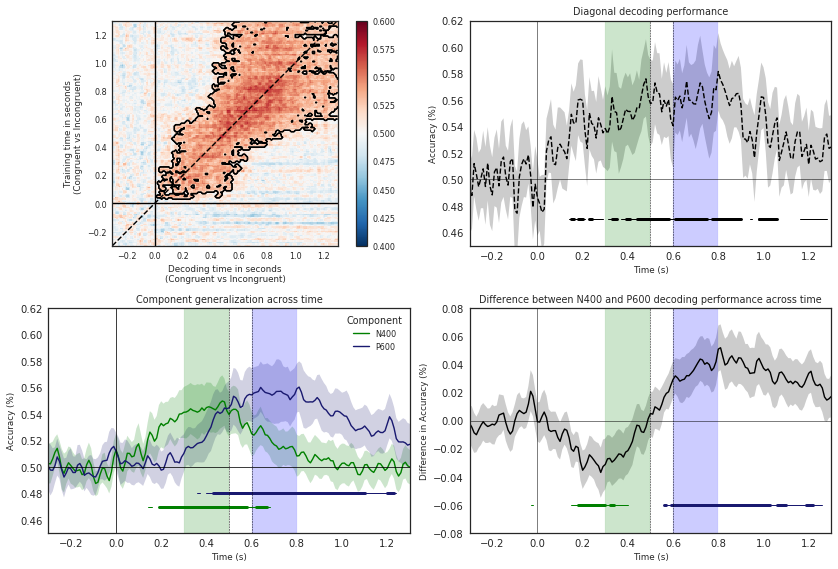

In [147]:
#thick lines index p<0.01
# thin lines index p<0.05

dec = "ridge"
scores = scores_dict2[dec]["scores"]
df1_, df_diag_, df_diff_, n1_, n2_, p1_, p2_, diag1_, diag2_, diff1_, diff2_ = shape_data(scores)
fg2 = plot_results(df1_, df_diag_, df_diff_, n1_, n2_, p1_, p2_, diag1_, diag2_, diff1_, diff2_, scores, 
                   decoder=dec, p_values=None, p_test=True
                  )

In [145]:
fg2.savefig(loc_files+"GATs_manu.pdf")

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [154]:
# significant time points for Ridge Regression Classifier for p<0.05 (and p<0.01)
print_clusters(n1_, n2_, testing="N400")
print_clusters(p1_, p2_, testing="P600")
print_clusters(diag1_, diag2_, testing="Diagonal")
print_clusters(diff1_, diff2_, testing="Difference")

N400 significant time points
0.05<p N400: [0.14000000000000001, 0.16]
0.05<p N400: [0.19, 0.68000000000000005]

0.01<p N400: [0.19, 0.57999999999999996]
0.01<p N400: [0.62, 0.67000000000000004]



P600 significant time points
0.05<p P600: [0.35999999999999999, 0.37]
0.05<p P600: [0.40000000000000002, 1.24]

0.01<p P600: [0.42999999999999999, 1.1000000000000001]
0.01<p P600: [1.2, 1.23]



Diagonal significant time points
0.05<p Diagonal: [0.14000000000000001, 0.20999999999999999]
0.05<p Diagonal: [0.23000000000000001, 0.28999999999999998]
0.05<p Diagonal: [0.31, 0.34999999999999998]
0.05<p Diagonal: [0.37, 0.90000000000000002]
0.05<p Diagonal: [0.93999999999999995, 0.94999999999999996]
0.05<p Diagonal: [0.97999999999999998, 1.01]
0.05<p Diagonal: [1.05, 1.0600000000000001]
0.05<p Diagonal: [1.1599999999999999, 1.28]

0.01<p Diagonal: [0.14999999999999999, 0.16]
0.01<p Diagonal: [0.17999999999999999, 0.20000000000000001]
0.01<p Diagonal: [0.23000000000000001, 0.23999999999999999]
0.01<p